# Data Proprocessing

- Making t, x, y, z arrays the same size
- Using averaging for reducing number of points for Human Data
- Column 'earthquake' with 0 or 1
    - Select Human data files before 50s to set at 'no'
    - Select other to be 'yes'
    
    
- Divide dataset into training, test and validation set

## Checking files

- All files have the same sampling rate: 25 Hertz. 

- Simulated files have `simulated['header']['mag']` 

- Human files collect data for 1 min before trigger time and that is all noise.

For prototyping, I use human files' 1 min pre triggertime as noise. I use 

In [1]:
import glob
import json
import random
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

%matplotlib inline
plt.style.use('ggplot')
random.seed(3)

In [2]:
table_dir = './MyShake_Training_Data/EQ/shake_table/'
table_files = glob.glob(table_dir + '*')
random.shuffle(table_files)


simulated_dir = './MyShake_Training_Data/EQ/simulated/'
simulated_files = glob.glob(simulated_dir + '*')
random.shuffle(simulated_files)

human_dir = './MyShake_Training_Data/Human/'
human_files = glob.glob(human_dir + '*')
random.shuffle(human_files)

In [3]:
def all_data(file):
    'Get dictionary from JSON file'
    with open(file, encoding='utf-8') as f:
        data=[json.loads(line) for line in f]
        data=data[0]
    return data

def get_data(data):
    '''
    Yuansi Chen's helper function to get the timestamp and 3-component acceleration data with small modifications. 
    '''
    # read in x, y, z data
    x = data['data']['x']
    y = data['data']['y']
    z = data['data']['z']
    
    size = min(len(x), len(y), len(z))
    x = x[:size]
    y = y[:size]
    z = z[:size]

    # calculate the timestamp
    # get the start time
    t0 = data['header']['starttime']
    npoints = len(x)
    sampling_rate = data['header']['sampling_rate']
    
    # get the end time 
    t1 = t0 + npoints / sampling_rate
    
    # form the timestamp
    t = np.arange(t0, t1, 1/sampling_rate)
    if len(t)>len(x):
        t = t[:len(x)] # Added this line to avoid rounding errors from generating extra point.
    elif len(t) < len(x):
        x = x[:len(t)]
        y = y[:len(t)]
        z = z[:len(t)]
    return t, x, y, z


def get_df(file, files_dir):
    'Function to transform file into pandas dataFrame'
    data = all_data(file)
    t, x, y, z = get_data(data)
    df = pd.DataFrame()
    df['t'] = t
    df['x'] = x
    df['y'] = y
    df['z'] = z
    if files_dir == human_dir:
        return df[:25*50] # If human, only get noise
    else:
        return df

In [4]:
mags = []
for file in simulated_files:
    simulated = all_data(file)
    mags.append(simulated['header']['mag'])



In [5]:
mags = np.asarray(mags)
print(scipy.stats.describe(mags))

DescribeResult(nobs=992, minmax=(4.9000000953674316, 9.0), mean=6.2171370699521038, variance=1.2724810546521585, skewness=1.1529370012961335, kurtosis=0.6726036880460131)


In [6]:
triggertime = []
for file in human_files[:100]:
    human = all_data(file)
    triggertime.append(human['header']['triggertime'])


In [7]:
triggertime = np.asarray(triggertime)
print(scipy.stats.describe(triggertime))

DescribeResult(nobs=100, minmax=(1414983843.329, 1432672243.448), mean=1423123618.7858701, variance=24325345571422.465, skewness=0.23891774377811018, kurtosis=-0.9974154447289649)


# Getting 'only noise' files

In [8]:
def get_df_many_files(n_files, files, files_dir):
    file_id = 0
    'Get dataFrame with n samples from directory'
    df_all = pd.DataFrame()
    for file in files[:n_files]:
        df = get_df(file, files_dir)
        df['id'] = file_id
        df_all = df_all.append(df, ignore_index=True)
        file_id += 1
    return df_all

#    data = pandas.read_excel(infile)
#    appended_data.append(data) ## store dataframes in list
#appended_data = pd.concat(appended_data, axis=1) #

# Selecting Features for Model Training

I created a dataframe for each of the three categories: human data, shake table data and simulated data. Each dataframe was made from 3 randomly selected files. I then used tsfresh to find the most relevant features to train the classification models for the time series.

In [9]:
df_human = get_df_many_files(10, human_files, human_dir)
#df_table = get_df_many_files(10, table_files, table_dir)
df_simulated = get_df_many_files(10, simulated_files, simulated_dir)

In [14]:
df_simulated.describe()

,t,x,y,z,id
count,3.744200e+04,37442.000000,37442.000000,37442.000000,37442.000000
mean,1.334586e+09,0.002604,-0.001166,1.002768,4.929277
std,1.915045e+08,0.020983,0.021839,0.021952,2.939308
min,0.000000e+00,-0.598841,-0.413827,0.803422,0.000000
25%,1.299855e+09,-0.004530,-0.008807,0.988565,3.000000
50%,1.396066e+09,0.000056,-0.000520,1.001147,5.000000
75%,1.408876e+09,0.006430,0.006492,1.018476,8.000000
max,1.408876e+09,0.588449,0.372217,1.225569,9.000000


In [15]:
df_human['id'] = df_human['id'] + 10

In [17]:
df_human.describe()

,t,x,y,z,id
count,1.250000e+04,12500.000000,12500.000000,12500.000000,12500.000000
mean,1.423227e+09,-0.002917,0.026782,-0.976832,14.500000
std,4.607726e+06,0.026089,0.041163,0.035486,2.872396
min,1.415673e+09,-0.040261,-0.048750,-1.061747,10.000000
25%,1.420380e+09,-0.022873,0.002707,-0.999346,12.000000
50%,1.422679e+09,-0.008086,0.009575,-0.967757,14.500000
75%,1.427575e+09,0.010923,0.035878,-0.961107,17.000000
max,1.431744e+09,0.063256,0.146266,-0.922431,19.000000


In [29]:
df_training = df_simulated.append(df_human, ignore_index=True)

In [31]:
df_training.describe()

,t,x,y,z,id
count,4.994200e+04,49942.000000,49942.000000,49942.000000,49942.000000
mean,1.356772e+09,0.001222,0.005829,0.507293,7.324737
std,1.702186e+08,0.022498,0.030466,0.857926,5.072517
min,0.000000e+00,-0.598841,-0.413827,-1.061747,0.000000
25%,1.302219e+09,-0.006756,-0.006422,-0.924329,4.000000
50%,1.396066e+09,-0.001082,0.002088,0.994004,6.000000
75%,1.415673e+09,0.007169,0.009643,1.009379,10.000000
max,1.431744e+09,0.588449,0.372217,1.225569,19.000000


In [32]:
X = extract_features(df_training, column_id='id', column_sort='t')

/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/Users/sofiatti/

In [27]:
Y = pd.DataFrame()
Y['id'] = np.arange(20)
Y['y'] = np.ones(20)
Y['y'][10:] = 0

/Users/sofiatti/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [49]:
y = np.ones(20)
y[10:] = 0
print (y)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


In [51]:
impute(X)
features_filtered = select_features(X, y)

[test_feature_significance] Feature z__mean_abs_change_quantiles__qh_0.2__ql_0.8 is constant
[test_feature_significance] Feature y__mean_abs_change_quantiles__qh_0.6__ql_0.8 is constant
[test_feature_significance] Feature z__has_duplicate_min is constant
[test_feature_significance] Feature z__mean_abs_change_quantiles__qh_0.6__ql_0.6 is constant
[test_feature_significance] Feature y__has_duplicate_max is constant
[test_feature_significance] Feature x__value_count__value_nan is constant
[test_feature_significance] Feature y__mean_abs_change_quantiles__qh_0.2__ql_0.6 is constant
[test_feature_significance] Feature z__symmetry_looking__r_0.05 is constant
[test_feature_significance] Feature y__mean_abs_change_quantiles__qh_0.6__ql_0.6 is constant
[test_feature_significance] Feature x__symmetry_looking__r_0.4 is constant
[test_feature_significance] Feature y__symmetry_looking__r_0.8500000000000001 is constant
[test_feature_significance] Feature x__large_number_of_peaks__n_3 is constant
[tes

In [52]:
print(features_filtered)

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [55]:
print(impute(X))

None


ValueError: could not convert string to float: 'x__longest_strike_below_mean'

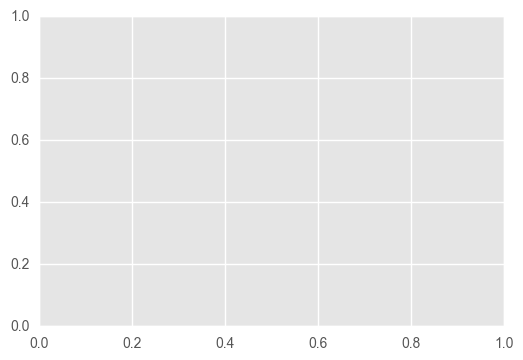

In [60]:
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

for x in X:
    plt.plot(x)
    plt.show()

In [ ]:
from tsfresh import extract_relevant_features

features_filtered_direct = extract_relevant_features(df_training, y, column_id='id', column_sort='t')

/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
/Users/sofiatti/anaconda3/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))
